In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
df = pd.read_csv("Skyserver_2019.csv", header=0)
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237666301628060000,47.372545,0.820621,18.69254,17.13867,16.55555,16.34662,16.17639,4849,301,5,771,8168632633242440000,STAR,0.000115,7255,56597,832
1,1237673706652430000,116.303083,42.455980,18.47633,17.30546,17.24116,17.32780,17.37114,6573,301,6,220,9333948945297330000,STAR,-0.000093,8290,57364,868
2,1237671126974140000,172.756623,-8.785698,16.47714,15.31072,15.55971,15.72207,15.82471,5973,301,1,13,3221211255238850000,STAR,0.000165,2861,54583,42
3,1237665441518260000,201.224207,28.771290,18.63561,16.88346,16.09825,15.70987,15.43491,4649,301,3,121,2254061292459420000,GALAXY,0.058155,2002,53471,35
4,1237665441522840000,212.817222,26.625225,18.88325,17.87948,17.47037,17.17441,17.05235,4649,301,3,191,2390305906828010000,GALAXY,0.072210,2123,53793,74


In [3]:
# import json
# af = df[['ra','dec','u','g','r','i','z']]
# data = json.dumps(json.loads(af.to_json(orient='records')))
df = df[['ra','dec','u','g','r','i','z', 'redshift', 'class']]

In [4]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
# Assuming that redshift is important (from book)
red_min = df['redshift'].min()
red_max = df['redshift'].max()
print(f'Min: {red_min} Max: {red_max}')

Min: -0.004136078 Max: 7.011245


In [6]:
df['redshift_cat'] = pd.cut(df['redshift'],
                            bins = [-6, 1, 2, 3, 4, 5, 10],
                            labels=[-1,.5,1,2,3,4])

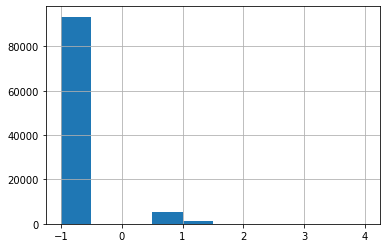

In [7]:
df['redshift_cat'].hist()

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['redshift_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    


In [9]:
def class_cat_proportions(data):
    return data["redshift_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": class_cat_proportions(df),
    "Stratified": class_cat_proportions(strat_test_set),
    "Random": class_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [10]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
-1.0,0.93400,0.9340,0.93385,-0.016060,0.000000
0.5,0.05289,0.0529,0.05235,-1.020987,0.018907
1.0,0.01229,0.0123,0.01260,2.522376,0.081367
2.0,0.00038,0.0004,0.00065,71.052632,5.263158
3.0,0.00013,0.0001,0.00010,-23.076923,-23.076923
4.0,0.00031,0.0003,0.00045,45.161290,-3.225806


In [11]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("redshift_cat", axis=1, inplace=True)

In [12]:
# X and y Train from stratified
df = strat_train_set.drop("class", axis=1) # drop labels for training set
df_labels = strat_train_set["class"].copy()

# X and y Test from stratified
x_test = strat_test_set.drop("class", axis=1)
y_test = strat_test_set['class'].copy()

In [13]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

In [14]:
# from sklearn.base import BaseEstimator, TransformerMixin

# # column index
# rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

# class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
#     def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
#         self.add_bedrooms_per_room = add_bedrooms_per_room
#     def fit(self, X, y=None):
#         return self  # nothing else to do
#     def transform(self, X):
#         rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
#         population_per_household = X[:, population_ix] / X[:, households_ix]
#         if self.add_bedrooms_per_room:
#             bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
#             return np.c_[X, rooms_per_household, population_per_household,
#                          bedrooms_per_room]
#         else:
#             return np.c_[X, rooms_per_household, population_per_household]

# attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
# housing_extra_attribs = attr_adder.transform(housing.values)

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
#         ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
# Only works if all categories are numerical (all predictor variables were for this dataset)
df_num_tr = num_pipeline.fit_transform(df)
df_num_test = num_pipeline.fit_transform(x_test)

In [16]:
from sklearn.compose import ColumnTransformer

num_attribs = list(df)
# cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
#         ("cat", OneHotEncoder(), cat_attribs),
    ])

df_prepared = full_pipeline.fit_transform(df)
df_test_prepared = full_pipeline.fit_transform(x_test)

In [17]:
# Everything until this point was data piepline processing. 

In [18]:
# First trying binary classification, lets start with trying to classify a Star

In [19]:
y_train_star = (df_labels == 'QSO')
y_test_star = (y_test == 'QSO')

In [20]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(df_prepared, y_train_star)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [21]:
some_class = df_test_prepared[4].reshape(1,-1)
some_class

array([[-0.70464051, -0.89116811, -1.27458918, -1.08802519, -0.88618388,
        -0.74908222, -0.63203691, -0.39432356]])

In [22]:
y_test

96328      STAR
7315       STAR
62530      STAR
47734    GALAXY
26183      STAR
          ...  
56975       QSO
79573      STAR
15920    GALAXY
43298    GALAXY
72898    GALAXY
Name: class, Length: 20000, dtype: object

In [23]:
sgd_clf.predict(some_class)

array([False])

In [24]:
# Evaluating the 'Quasar Finder'

In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, df_prepared, y_train_star, cv=3, scoring="accuracy")

array([0.99107511, 0.99077512, 0.98833721])

In [26]:
# A better way to evaluate performace of a classifier is the confusion matrix.
# Confusion Matrix

In [27]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, df_prepared, y_train_star, cv=3)

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_star, y_train_pred)

array([[71466,   172],
       [  623,  7739]], dtype=int64)

In [29]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_star, y_train_pred)

0.9782581216028315

In [30]:
recall_score(y_train_star, y_train_pred)

0.9254962927529299

In [31]:
from sklearn.metrics import f1_score
f1_score(y_train_star, y_train_pred)

0.9511460701775948

In [32]:
y_scores = cross_val_predict(sgd_clf, df, y_train_star, cv=3,
                             method="decision_function")

In [33]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_star, y_scores)

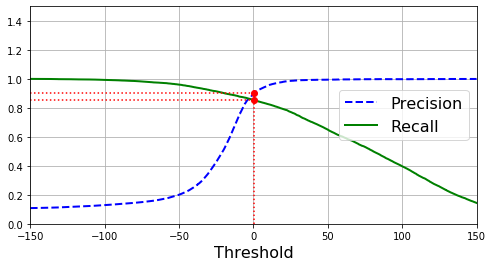

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-150, 150, 0, 1.5])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-150, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-150, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
# save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

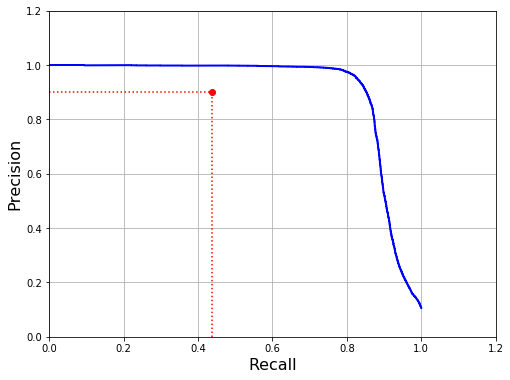

In [35]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1.2, 0, 1.2])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
# save_fig("precision_vs_recall_plot")
plt.show()

In [37]:
# Multiclass Classification

# Scalar vector (usally for binary but can with OvO or OvR)
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(df_prepared, df_labels)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [40]:
svm_clf.predict(some_class)

array(['STAR'], dtype=object)

In [45]:
some_class_scores = svm_clf.decision_function(some_class)
some_class_scores

array([[ 1.11358588, -0.25192506,  2.24016349]])

In [46]:
svm_clf.classes_

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [47]:
#2 Re-fitting the Stochasitic Gradient Decent
sgd_clf.fit(df_prepared, df_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
sgd_clf.predict(some_class)

array(['STAR'], dtype='<U6')

In [58]:
df_labels.value_counts()

GALAXY    41198
STAR      30440
QSO        8362
Name: class, dtype: int64

In [52]:
y_train_pred_all = cross_val_predict(sgd_clf, df_prepared, df_labels, cv=3)
conf_mx = confusion_matrix(df_labels, y_train_pred_all)
conf_mx

array([[39565,   200,  1433],
       [ 1104,  7255,     3],
       [  616,    12, 29812]], dtype=int64)

In [55]:
sgd_clf.classes_

array(['GALAXY', 'QSO', 'STAR'], dtype='<U6')

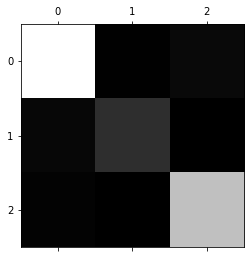

In [54]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [49]:
#2 3 Random Forrest 
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(df_prepared, df_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [50]:
forest_clf.predict(some_class)

array(['STAR'], dtype=object)

In [57]:
X

GALAXY    41198
STAR      30440
QSO        8362
Name: class, dtype: int64